# Landscape or Cityscape?

The idea behind this notebook is to test out various CNNs to determine which networks are best suited to determining if an picture is an image of a city or an image of nature. My data sources for this experiment are the subreddits r/earthporn and r/cityporn. I chose these subreddits as they are focused and fairly strictly moderated. Each contains only aestetically pleasing pictures of landscapes and cityscapes respectively. I took all the directly linked images from these subreddits since 1/1/17 that have over a certain threshold of upvotes, which gave me a few thousand images that are almost entirely either a picture of a natural landscape or a picture of a cityscape

I will use keras' implementations of VGG16 as feature extraction and experiment with a few different caps to find the best classifier for this problem

In [1]:
#general imports and commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
%matplotlib inline
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
#keras specific imports
from keras import Model, Input
from keras.layers import Dense, Flatten,GlobalMaxPool2D,Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from keras.applications import VGG16,vgg16

In [3]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000 

In [4]:
#functions for the project that I put in a .py to clean up the notebook
from importlib import reload
import project_utils
reload(project_utils)

<module 'project_utils' from '/home/ubuntu/Landscape_or_Cityscape/project_utils.py'>

In [5]:
#loading pretrained model weights
VGG = VGG16(weights = 'imagenet', include_top = False, input_shape= (224,224,3))

The first base model I will try is [VGG16](https://arxiv.org/abs/1409.1556). I will remove the top layers of the network, keeping only the convolutions as feature extraction then feed those features through a variety of classifier networks. The networks I am going to use for this are:
+ Global max pooling into a 100 unit fully connected layer into a softmax output layer
+ Global max pooling into a 200 unit fully connected layer then a second dense layer with 100 units then softmax output
+ Global max pooling into a 500 unity fully connected layer then a softmax output layer

Since I will be using keras' [ImageDataGenerator.flow_from_directory](https://keras.io/preprocessing/image/) function to train these networks I will train 4 of each of these to reduce potential variance in the semi-randomly generated training sets

In [6]:
# This function takes in headless model (some pretrained CNN)
# and adds a max pooling and a dense fully connected layer to it.
def create_model1(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = GlobalMaxPool2D()(X)
    X = Dense(100, activation = 'relu',name = '1')(X)
    predictions = Dense(2 , activation = 'softmax',name = '2')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

#same as the first function but there are two dense layers rather than just one 
def create_model2(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = GlobalMaxPool2D()(X)
    X = Dense(200, activation = 'relu', name = '1')(X)
    X = Dense(100, activation = 'relu',name = '2')(X)
    predictions = Dense(2 , activation = 'softmax',name = '3')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

#a model with one larger dense layer 
def create_model3(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = GlobalMaxPool2D()(X)
    X = Dense(500, activation = 'relu',name = '2')(X)
    predictions = Dense(2 , activation = 'softmax',name = '3')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model



In [7]:
#Preparing data generators
#this keras utilitiy will continously generate images that have been slightly rotated 
#or shifted or flipped from the directories where I stored the images for both training and validation
data_gen = ImageDataGenerator(shear_range= 0.2,
                                    zoom_range= 0.2,
                                    horizontal_flip= True,
                                    width_shift_range=0.2,
                                    height_shift_range = 0.2,
                                    preprocessing_function= (lambda x: x/127.5 - 1))                                           

train_generator = data_gen.flow_from_directory('./images/train',
                                               batch_size = 16,
                                               target_size= (224,224),
                                               class_mode= 'categorical')

validation_generator = data_gen.flow_from_directory('./images/validation',
                                                    batch_size = 16,
                                                    target_size= (224,224),
                                                    class_mode= 'categorical')

#creating multiple model instances for each network structure
max_pool_one_layer = [create_model1(VGG) for i in range(0,4)]
for model in max_pool_one_layer:
    model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

    
max_pool_two_layer = [create_model2(VGG) for i in range(0,4)]
for model in max_pool_two_layer:
    model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

    
max_pool_one_big = [create_model3(VGG) for i in range(0,4)]
for model in max_pool_one_big:
    model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

    
model_types = [max_pool_one_layer,max_pool_two_layer, max_pool_one_big]


Found 4850 images belonging to 2 classes.
Found 605 images belonging to 2 classes.


In [8]:
#this will cause the model to stop fitting if the validation loss has gone down for 3 epochs
#this is to help prevent overfitting by training the model for too long
early_stopping = EarlyStopping(min_delta = .01, 
                               patience = 3,
                               verbose = 1,
                               mode = 'min')

In [9]:
i = 0
total = len([x for y in model_types for x in y])
for model_list in model_types:
    for model in model_list:
        model.fit_generator(generator = train_generator, 
                            epochs=20,
                            steps_per_epoch= 40, #there are 16 images per step so this is 640 per epoch
                            callbacks = [early_stopping],
                            validation_data = validation_generator,
                            validation_steps=40, #validation on 640 images
                            workers=12,
                            use_multiprocessing=True,
                            verbose = 1) 
        i+=1
        print("{}/{} models trained".format(i,total))    


Epoch 1/20
40/40 [==============================] - 40s 995ms/step - loss: 0.3787 - acc: 0.8594 - val_loss: 0.2449 - val_acc: 0.9137
Epoch 2/20
40/40 [==============================] - 32s 807ms/step - loss: 0.2445 - acc: 0.9172 - val_loss: 0.2059 - val_acc: 0.9325
Epoch 3/20
40/40 [==============================] - 29s 729ms/step - loss: 0.2291 - acc: 0.9203 - val_loss: 0.2453 - val_acc: 0.9121
Epoch 4/20
40/40 [==============================] - 28s 690ms/step - loss: 0.2058 - acc: 0.9250 - val_loss: 0.2051 - val_acc: 0.9356
Epoch 5/20
40/40 [==============================] - 27s 669ms/step - loss: 0.1970 - acc: 0.9391 - val_loss: 0.1834 - val_acc: 0.9356
Epoch 6/20
40/40 [==============================] - 30s 753ms/step - loss: 0.2542 - acc: 0.9156 - val_loss: 0.1930 - val_acc: 0.9215
Epoch 7/20
40/40 [==============================] - 30s 738ms/step - loss: 0.2392 - acc: 0.9156 - val_loss: 0.1952 - val_acc: 0.9356
Epoch 8/20
40/40 [==============================] - 30s 738ms/step - 

In [10]:
#makes the test set which I set aside when gathering data
X_test, y_test = project_utils.get_test()

Now that I have trained all these networks its time to evaluate them. For this task my metrics will primarily be ROCAUC and visual examination of the confusion matrix. These evaluations will all be done on a test set that was held out from the data while I was gathering the pictures. 

In [11]:
# the function to evaluate each group of models
def evaluate_model_list(model_list):
    rocs, accs, losses = [], [] , []
    for model in model_list:
        metrics= project_utils.evaluate_and_confusion_matrix(X_test,y_test, model, print_res=True)
        rocs.append(metrics[0])
        accs.append(metrics[1])
        losses.append(metrics[2])
    print("Mean ROC AUC score: {}".format(sum(rocs)/len(rocs)))
    print("Mean accuracy score: {}".format(sum(accs)/len(accs)))
    print("Mean loss: {}".format(sum(losses)/len(losses)))

In [12]:
#Evaluate 2 layer top
evaluate_model_list(max_pool_one_layer)


605/605 [==============================] - 9s 14ms/step
accuracy: 0.9520661157024793, loss: 0.13867663023762467 
ROC AUC score: 0.9751305683563749
         city  earth  totals
city    114.0    3.0   117.0
earth    26.0  462.0   488.0
totals  140.0  465.0   605.0
605/605 [==============================] - 5s 9ms/step
accuracy: 0.9338842975206612, loss: 0.21808681002286964 
ROC AUC score: 0.9731336405529954
         city  earth  totals
city    101.0    1.0   102.0
earth    39.0  464.0   503.0
totals  140.0  465.0   605.0
605/605 [==============================] - 5s 9ms/step
accuracy: 0.9421487603305785, loss: 0.210520576073765 
ROC AUC score: 0.9727035330261137
         city  earth  totals
city    106.0    1.0   107.0
earth    34.0  464.0   498.0
totals  140.0  465.0   605.0
605/605 [==============================] - 5s 9ms/step
accuracy: 0.9388429752066115, loss: 0.2227499596501339 
ROC AUC score: 0.9716129032258065
         city  earth  totals
city    104.0    1.0   105.0
earth    36.

In [13]:
#Evaluate 2 layer top
evaluate_model_list(max_pool_two_layer)

605/605 [==============================] - 5s 9ms/step
accuracy: 0.9537190082644628, loss: 0.1539309143219605 
ROC AUC score: 0.9709216589861751
         city  earth  totals
city    114.0    2.0   116.0
earth    26.0  463.0   489.0
totals  140.0  465.0   605.0
605/605 [==============================] - 5s 9ms/step
accuracy: 0.9454545454545454, loss: 0.15744699136592633 
ROC AUC score: 0.975084485407066
         city  earth  totals
city    108.0    1.0   109.0
earth    32.0  464.0   496.0
totals  140.0  465.0   605.0
605/605 [==============================] - 5s 9ms/step
accuracy: 0.9388429752066115, loss: 0.21894418567434445 
ROC AUC score: 0.9715745007680492
         city  earth  totals
city    104.0    1.0   105.0
earth    36.0  464.0   500.0
totals  140.0  465.0   605.0
605/605 [==============================] - 5s 9ms/step
accuracy: 0.9272727272727272, loss: 0.21829728545113045 
ROC AUC score: 0.9675268817204301
         city  earth  totals
city     97.0    1.0    98.0
earth    43.

In [14]:
#evaluate model with large top layer 
evaluate_model_list(max_pool_one_big)

605/605 [==============================] - 5s 9ms/step
accuracy: 0.9603305785123967, loss: 0.13276292610882728 
ROC AUC score: 0.9727956989247312
         city  earth  totals
city    119.0    3.0   122.0
earth    21.0  462.0   483.0
totals  140.0  465.0   605.0
605/605 [==============================] - 5s 9ms/step
accuracy: 0.9289256198347108, loss: 0.24588995128100322 
ROC AUC score: 0.9668663594470046
         city  earth  totals
city     98.0    1.0    99.0
earth    42.0  464.0   506.0
totals  140.0  465.0   605.0
605/605 [==============================] - 5s 9ms/step
accuracy: 0.9487603305785124, loss: 0.18764712226554012 
ROC AUC score: 0.9733794162826421
         city  earth  totals
city    110.0    1.0   111.0
earth    30.0  464.0   494.0
totals  140.0  465.0   605.0
605/605 [==============================] - 5s 9ms/step
accuracy: 0.9537190082644628, loss: 0.16734589086152798 
ROC AUC score: 0.971121351766513
         city  earth  totals
city    114.0    2.0   116.0
earth    26

It looks like the single layer with 100 units is doing better than the other networks, but by such a small margin that I can't be confident that it really is better at this task. Additionally It seems that the networks are all having a problem where many of the city pictures are being mistaken for earth pictures and not the other way around. It seems that I need to take a look at my threshold.

In [46]:
from sklearn.metrics import f1_score
def get_multiple_f1_scores(y_true, predictions):
    '''Takes an F1 score for every threshold (0,1) in steps of .02'''
    scores = []
    for threshold in np.linspace(0,1,51):
        actual = np.argmax(y_true,axis = 1)
        pred = predictions[:,1] > threshold
        f1 = f1_score(actual,pred)
        scores.append(f1)
    return scores

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


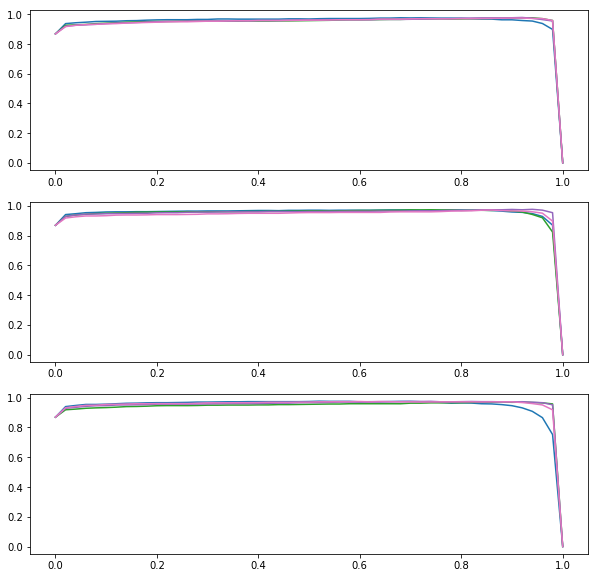

In [48]:
fig, axs = plt.subplots(ncols = 1, nrows= 3, figsize = (10,10))
for ind,model_list in enumerate(model_types):
    for model in model_list:
        preds = model.predict(X_test)
        f1s = get_multiple_f1_scores(y_test, preds)
        axs[ind].plot(np.linspace(0,1,51),f1s)
plt.show()

Based on this it seems that the problem is not the threshold but rather there must be something that the classifier is missing. Lets take a look at the mistakes and see if there is any patterns. For now I am going to focus on the first 2 layer model for simplicity

In [50]:
#getting the filepaths for the city images
city_image_paths = os.listdir('images/test/cityporn_3_10')
print(len(city_image_paths))

140


In [59]:
def get_mistakes(paths, model):
    mistakes = []
    for path in paths:
        prepped = project_utils.prep_for_model('images/test/cityporn_3_10/'+path)
        pred = model.predict(prepped)
        if pred[0,0] < pred[0,1]:
            mistakes.append('images/test/cityporn_3_10/'+path)
    return mistakes

In [60]:
#function to help with error analysis and sanity checking
def show_and_predict(path,model_list):
    pylab.imshow(pylab.imread(path))
    prepped = project_utils.prep_for_model(path)
    for model in model_list:
        pred = model.predict(prepped)
        print("p(city): {}, p(nature): {}".format(pred[0,0],pred[0,1]),"\n")
        

In [61]:
mistakes = get_mistakes(city_image_paths,max_pool_two_layer[0])

In [63]:
len(mistakes)

26

p(city): 0.026367444545030594, p(nature): 0.9736325740814209 

p(city): 0.08296022564172745, p(nature): 0.9170398116111755 

p(city): 0.07016567140817642, p(nature): 0.9298343062400818 

p(city): 0.04573153331875801, p(nature): 0.9542685151100159 



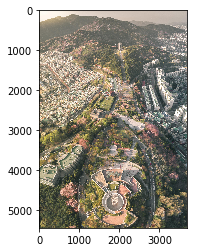

In [62]:
show_and_predict(mistakes[0], max_pool_two_layer)

Okay this one seems understandable there is a lot of green and vegetation in the image lets see what else we can find 

p(city): 0.013722842559218407, p(nature): 0.986277163028717 

p(city): 0.055987805128097534, p(nature): 0.9440121650695801 

p(city): 0.005492443684488535, p(nature): 0.9945076107978821 

p(city): 0.014859000220894814, p(nature): 0.9851410388946533 



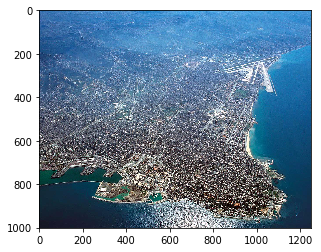

In [64]:
show_and_predict(mistakes[5], max_pool_two_layer)

p(city): 0.031199216842651367, p(nature): 0.9688008427619934 

p(city): 0.07219456136226654, p(nature): 0.9278054237365723 

p(city): 0.022439008578658104, p(nature): 0.9775609374046326 

p(city): 0.012122088111937046, p(nature): 0.9878779649734497 



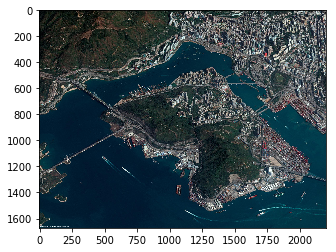

In [65]:
show_and_predict(mistakes[10], max_pool_two_layer)

p(city): 0.4442282021045685, p(nature): 0.5557717680931091 

p(city): 0.23682807385921478, p(nature): 0.763171911239624 

p(city): 0.17396576702594757, p(nature): 0.8260342478752136 

p(city): 0.04570863023400307, p(nature): 0.9542914032936096 



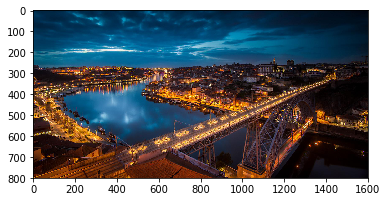

In [68]:
show_and_predict(mistakes[18], max_pool_two_layer)

So there seems to be a pattern of a lot of arial shots in the mistakes, at least in this last mistake the network seemed more undecided about it rather than confident as it was in the others

## Conclusions:

These networks are doing pretty well currently despite the flaws. The AUC scores are pretty good and most of the time it gets the classification right.
I think the most promising next step to improve the model would be to collect more images of urban enviroments, especially wide or arial shots of cities. I think the likely problem right now is that I don't have quite enough data for cities in comparison to nature shots. 